In [1]:
import re
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import codecs

import websocket
import thread
import threading
import time

from difflib import SequenceMatcher
import networkx as nx
import nltk
from nltk import word_tokenize,sent_tokenize,ne_chunk
from nltk.corpus import stopwords

from watson_developer_cloud import NaturalLanguageUnderstandingV1
from watson_developer_cloud.natural_language_understanding_v1 \
  import Features, EntitiesOptions, SemanticRolesOptions, RelationsOptions, KeywordsOptions

In [2]:
#!pip install websocket-client

In [3]:
# load the configuration file.

input_file  = file("../configuration/config_classification.txt", "r")
config_classification_json = json.loads(input_file.read().decode("utf-8-sig"))
print(type(config_classification_json))



<type 'dict'>


In [4]:
# upload NLU credentials   

natural_language_understanding = NaturalLanguageUnderstandingV1(
  username= '',
  password='',
  version='2017-02-27')



In [5]:
category ={'blood', 'medicine', 'medical help', 'napkin', 'clothes','food', 'mobile recharge', 'donation', 'water'}
seekers = [r'around.*now.*\?', r'now.*around.*\?',r'now.*around',r'need.*', r'need.*help',r'help.*need[ed]?',r'need.*help.*to.*contact', r'needed', r'volunteers?', r'volunteer?', r'pregnant.*lady.*stuck', r'need[s]?.*help', r'need.*without.*if',r'How.*is' ,r'any.*information,any.*info',r'Does.*anyone.*-.*.*need',r'can.*someone.*',r'someone.*can,available\?']
helpers = [r'if.*you.*need', r'Ready.*to.*help', r'available\s+',r'available.*contact',r'available.*call',r'\bif\b.*need',r'if.*call,if.*contact',r'if.*needed',r'food.*pockets+.*call',r'volunteers.*\?',r'volunteers.*\?',r'needed\?',r'need.*\?',r'available',r'give', r'want to donate', r'ready to help', r'in need of']


In [6]:
def analyze_using_NLU(text_content):
    '''
    Call Watson Natural Language Understanding service to obtain analysis results.
    '''
    response = natural_language_understanding.analyze(
        text= text_content,
        features=Features(
        entities=EntitiesOptions(),
#         relations=RelationsOptions(),
#         keywords= KeywordsOptions())
    ))
    return response

In [7]:
def split_sentences(text):
    """ Split text into sentences.
    """
    sentence_delimiters = re.compile(u'[\\[\\]\n.!?]')
    sentences = sentence_delimiters.split(text)
    return sentences

def split_into_tokens(text):
    """ Split text into tokens.
    """
    tokens = nltk.word_tokenize(text)
    return tokens
    
def POS_tagging(text):
    """ Generate Part of speech tagging of the text.
    """
    POSofText = nltk.tag.pos_tag(text)
    return POSofText

def keyword_tagging(tag,tagtext,text):
    """ Tag the text matching keywords.
    """
    if (text.lower().find(tagtext.lower()) != -1):
        return text[text.lower().find(tagtext.lower()):text.lower().find(tagtext.lower())+len(tagtext)]
    else:
        return 'UNKNOWN'
    
def regex_tagging(tag,regex,text):
    """ Tag the text matching REGEX.
    """    
    p = re.compile(regex, re.IGNORECASE)
    matchtext = p.findall(text)
    regex_list=[]    
    if (len(matchtext)>0):
        for regword in matchtext:
            regex_list.append(regword)
    return regex_list

def chunk_tagging(tag,chunk,text):
    """ Tag the text using chunking.
    """
    parsed_cp = nltk.RegexpParser(chunk)
    pos_cp = parsed_cp.parse(text)
    chunk_list=[]
    for root in pos_cp:
        if isinstance(root, nltk.tree.Tree):               
            if root.label() == tag:
                chunk_word = ''
                for child_root in root:
                    chunk_word = chunk_word +' '+ child_root[0]
                chunk_list.append(chunk_word)
    return chunk_list
    
def augument_NLUResponse(responsejson,updateType,text,tag):
    """ Update the NLU response JSON with augumented classifications.
    """
    if(updateType == 'keyword'):
        if not any(d.get('text', None) == text for d in responsejson['keywords']):
            responsejson['keywords'].append({"text":text,"relevance":0.5})
    else:
        if not any(d['text'].replace('#', " ") in text if '#' in d['text'] else d['text'] in text  for d in responsejson['entities']):
            responsejson['entities'].append({"type":tag,"text":text,"relevance":0.5,"count":1})        
    

def classify_text(text, config):
    """ Perform augumented classification of the text.
    """
    
    response = analyze_using_NLU(text)
    responsejson = response
    
    sentenceList = split_sentences(text)
    
    tokens = split_into_tokens(text)
    
    postags = POS_tagging(tokens)
    
    configjson = config
    
    for stages in configjson['configuration']['classification']['stages']:
        for steps in stages['steps']:
            if (steps['type'] == 'keywords'):
                for keyword in steps['keywords']:
                    for word in sentenceList:
                        wordtag = keyword_tagging(keyword['tag'],keyword['text'],word)
                        if(wordtag != 'UNKNOWN'):
                            augument_NLUResponse(responsejson,'entities',wordtag,keyword['tag'])
            elif(steps['type'] == 'd_regex'):
                for regex in steps['d_regex']:
                    for word in sentenceList:
                        regextags = regex_tagging(regex['tag'],regex['pattern'],word)
                        if (len(regextags)>0):
                            for words in regextags:
                                augument_NLUResponse(responsejson,'entities',words,regex['tag'])
            elif(steps['type'] == 'chunking'):
                for chunk in steps['chunk']:
                    chunktags = chunk_tagging(chunk['tag'],chunk['pattern'],postags)
                    if (len(chunktags)>0):
                        for words in chunktags:
                            augument_NLUResponse(responsejson,'entities',words,chunk['tag'])
            else:
                print('UNKNOWN STEP')
    
    return responsejson

def replace_unicode_strings(response):
    """ Convert dict with unicode strings to strings.
    """
    if isinstance(response, dict):
        return {replace_unicode_strings(key): replace_unicode_strings(value) for key, value in response.iteritems()}
    elif isinstance(response, list):
        return [replace_unicode_strings(element) for element in response]
    elif isinstance(response, unicode):
        return response.encode('utf-8')
    else:
        return response

In [8]:
tweet_1 = "If you Need medical help in Royapuram, call Dr. Raghul 09944611395,can assist over phone also #ChennaiVolunteer #ChennaiRainsHelp"
tweet_2 = "Anybody in need of mobile recharge, contact Sahil on 919962335383. #ChennaiRainsHelp Please RT!"
tweet_3 = "Medicines available at Apollo Pharmacy - Free home delivery, Call 18605000101 #ChennaiVolunteer #ChennaiRainsHelp"
tweet_4 = "+919884788862 Ramnath. He and 3 others want to donate blood. #ChennaiVolunteer #ChennaiRains"
tweet_5 = "Nandambakkam cantonment marraige hall has 700 people who need food ph: 9944422220 #chennairescue"
tweet_6 = "Anybody in need of food contact Vijay on 9646118841 #chennairescue"
tweets = [tweet_1,tweet_2, tweet_3, tweet_4, tweet_5, tweet_6 ]

In [9]:
tweets

['If you Need medical help in Royapuram, call Dr. Raghul 09944611395,can assist over phone also #ChennaiVolunteer #ChennaiRainsHelp',
 'Anybody in need of mobile recharge, contact Sahil on 919962335383. #ChennaiRainsHelp Please RT!',
 'Medicines available at Apollo Pharmacy - Free home delivery, Call 18605000101 #ChennaiVolunteer #ChennaiRainsHelp',
 '+919884788862 Ramnath. He and 3 others want to donate blood. #ChennaiVolunteer #ChennaiRains',
 'Nandambakkam cantonment marraige hall has 700 people who need food ph: 9944422220 #chennairescue',
 'Anybody in need of food contact Vijay on 9646118841 #chennairescue']

In [10]:
list_of_people=[]
for tweet in tweets:
    json = classify_text(tweet,config_classification_json)
    dict_of_people ={} 

    max_ratio_item={}
    
    
    for i in seekers:
        if(re.search(i, tweet, re.IGNORECASE)):
            dict_of_people['classification'] = "seeker"
            print(re.search(i, tweet, re.IGNORECASE).group())


    for i in helpers:
        if(re.search(i, tweet, re.IGNORECASE)):
            dict_of_people['classification'] = "helper"
            print(re.search(i, tweet, re.IGNORECASE).group())




    for item in category:
        s = SequenceMatcher(None,item, tweet)
        max_ratio_item[s.ratio()] = item


    import collections
    od = collections.OrderedDict(sorted(max_ratio_item.items()))
    for ratio, item in od.iteritems():
        if(item.lower() in tweet.lower()):
            print(item)
            dict_of_people['category'] = item
            print("#######") 

    for entity in range(len(json['entities'])):
        if(json['entities'][entity]['type'] == 'Person' or  json['entities'][entity]['type'] == 'NAME' or json['entities'][entity]['type'] == 'Company'):
            print(json['entities'][entity]['text'])
            dict_of_people['name'] = json['entities'][entity]['text']
            print("#######")
        if(json['entities'][entity]['type'] == 'PhoneNumber'):
            print(json['entities'][entity]['text'])
            dict_of_people['PhoneNumber'] = json['entities'][entity]['text']
            print("#######")
            
    list_of_people.append(dict_of_people)






Need medical help in Royapuram, call Dr. Raghul 09944611395,can assist over phone also #ChennaiVolunteer #ChennaiRainsHelp
Need medical help in Royapuram, call Dr. Raghul 09944611395,can assist over phone also #ChennaiVolunteer #ChennaiRainsHelp
Volunteer
Volunteer
Need medical help in Royapuram, call Dr. Raghul 09944611395,can assist over phone also #ChennaiVolunteer #ChennaiRainsHelp
If you Need
If you Need
medical help
#######
Dr. Raghul
#######
0994461139
#######
need of mobile recharge, contact Sahil on 919962335383. #ChennaiRainsHelp Please RT!
need of mobile recharge, contact Sahil on 919962335383. #ChennaiRainsHelp
need of mobile recharge, contact Sahil on 919962335383. #ChennaiRainsHelp
in need of
mobile recharge
#######
Sahil
#######
9199623353
#######
Volunteer
Volunteer
available 
available at Apollo Pharmacy - Free home delivery, Call
available
medicine
#######
Apollo Pharmacy
#######
1860500010
#######
Volunteer
Volunteer
want to donate
blood
#######
9198847888
#######
 R

In [11]:
list_of_people

[{'PhoneNumber': '0994461139',
  'category': 'medical help',
  'classification': 'helper',
  'name': u'Dr. Raghul'},
 {'PhoneNumber': '9199623353',
  'category': 'mobile recharge',
  'classification': 'helper',
  'name': u'Sahil'},
 {'PhoneNumber': '1860500010',
  'category': 'medicine',
  'classification': 'helper',
  'name': u'Apollo Pharmacy'},
 {'PhoneNumber': '9198847888',
  'category': 'blood',
  'classification': 'helper',
  'name': ' Ramnath'},
 {'PhoneNumber': '9944422220',
  'category': 'food',
  'classification': 'seeker',
  'name': ' Nandambakkam'},
 {'PhoneNumber': '9646118841',
  'category': 'food',
  'classification': 'helper',
  'name': u'Vijay'}]

In [12]:
list_of_people_dataframe = pd.DataFrame(list_of_people)

In [13]:
list_of_people_dataframe

,PhoneNumber,category,classification,name
0,0994461139,medical help,helper,Dr. Raghul
1,9199623353,mobile recharge,helper,Sahil
2,1860500010,medicine,helper,Apollo Pharmacy
3,9198847888,blood,helper,Ramnath
4,9944422220,food,seeker,Nandambakkam
5,9646118841,food,helper,Vijay


In [14]:
list_of_people_dataframe['relationship'] = np.where(list_of_people_dataframe['classification'] == 'helper', 'provides', 'seeking')

In [15]:
graph= []
for index, row in list_of_people_dataframe.iterrows():
    tuplerel=[]
    tuplerel.append(row['name'])
    tuplerel.append(row['relationship'])
    tuplerel.append(row['category'])
    print(tuple(tuplerel))
    graph.append(tuple(tuplerel))

(u'Dr. Raghul', 'provides', 'medical help')
(u'Sahil', 'provides', 'mobile recharge')
(u'Apollo Pharmacy', 'provides', 'medicine')
(' Ramnath', 'provides', 'blood')
(' Nandambakkam', 'seeking', 'food')
(u'Vijay', 'provides', 'food')


In [16]:
graph

[(u'Dr. Raghul', 'provides', 'medical help'),
 (u'Sahil', 'provides', 'mobile recharge'),
 (u'Apollo Pharmacy', 'provides', 'medicine'),
 (' Ramnath', 'provides', 'blood'),
 (' Nandambakkam', 'seeking', 'food'),
 (u'Vijay', 'provides', 'food')]

In [17]:
def draw_simple_graph(graph):

    nodes = []
    labels = []
    edges = []
    # extract nodes from graph
    for tuples in graph:
        nodes.append(tuples[0])
        nodes.append(tuples[2])
        
    # extract edges from graph
    for edgepairs in graph:
        edges.append((edgepairs[0],edgepairs[2]))        
    # extract edge labels from graph
    for edgetuples in graph:
        labels.append(edgetuples[1])
    # create networkx graph
    G=nx.Graph()
    # add nodes
    for node in nodes:
        G.add_node(node)
    # add edges
    for edgetuples in graph:
        G.add_edge(edgetuples[0], edgetuples[2], relation=edgetuples[1])

    # draw graph
    pos = nx.circular_layout(G,dim=2)
    print(pos)
    d = nx.degree(G)
    nx.draw(G, pos,with_labels = True, font_size=10)
    edge_labels = dict(zip(edges, labels))
    nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels , font_size=8)

    # show graph
    plt.show()
    
    return G, pos, edge_labels 


# d = nx.degree(g)

# nx.draw(g, nodelist=d.keys(), node_size=[v * 100 for v in d.values()])
# plt.show()

{'food': array([ 0.98982149,  0.5       ], dtype=float32), 'medical help': array([ 0.15388249,  0.8817606 ], dtype=float32), 'mobile recharge': array([ 0.69452327,  0.95949298], dtype=float32), u'Dr. Raghul': array([ 0.41279078,  1.        ], dtype=float32), u'Sahil': array([ 0.90963203,  0.7731002 ], dtype=float32), 'blood': array([  3.01087866e-08,   6.42314851e-01], dtype=float32), ' Ramnath': array([ 0.        ,  0.35768527], dtype=float32), 'medicine': array([ 0.15388237,  0.11823949], dtype=float32), u'Apollo Pharmacy': array([ 0.41279063,  0.        ], dtype=float32), u'Vijay': array([ 0.6945231 ,  0.04050695], dtype=float32), ' Nandambakkam': array([ 0.90963197,  0.22689979], dtype=float32)}


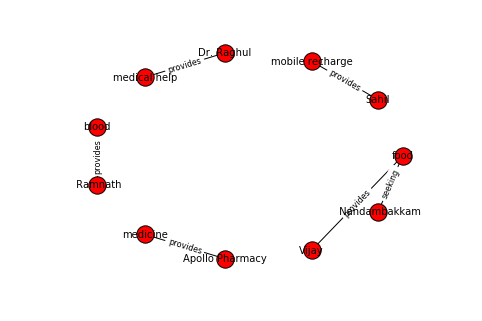

In [18]:
# create networkx graph
G=nx.Graph()

G, pos, edge_labels=  draw_simple_graph(graph)

In [19]:
edgeDict = G.edges(data=True)
edgeDict


[('food', u'Vijay', {'relation': 'provides'}),
 ('food', ' Nandambakkam', {'relation': 'seeking'}),
 (u'Sahil', 'mobile recharge', {'relation': 'provides'}),
 (u'Dr. Raghul', 'medical help', {'relation': 'provides'}),
 ('blood', ' Ramnath', {'relation': 'provides'}),
 ('medicine', u'Apollo Pharmacy', {'relation': 'provides'})]

In [20]:
def creategraphDataframe():
    f = lambda x,index:tuple( i[index] for i in x)

    tup1 = f(edgeDict,0)
    tup2 = f(edgeDict,1)
    tup3 = f(edgeDict,2)
    tup4 =[]
#     print tup1
#     print tup2
#     print tup3[0].values()

    for i in range(len(tup3)):
        tup4.append(tup3[i]['relation'])

#     print tup4

    graph_dataframe = pd.DataFrame(list(zip(tup1, tup2, tup4)), columns=['node_1','node_2', 'relation'])
    return graph_dataframe

In [21]:
graph_dataframe = creategraphDataframe()
graph_dataframe

,node_1,node_2,relation
0,food,Vijay,provides
1,food,Nandambakkam,seeking
2,Sahil,mobile recharge,provides
3,Dr. Raghul,medical help,provides
4,blood,Ramnath,provides
5,medicine,Apollo Pharmacy,provides


In [22]:
def get_mapping_d3_network():
    """ Create an mapping json for display by d3js network widget
    """
    nodes =[]
    links =[] 
    nodes_array = []
    result = {}
    for index, row in graph_dataframe.iterrows():
        node1 = row['node_1']
        node2 = row['node_2']
        
        relation = row['relation']
        node = {}
        node['id'] = node1
        if node not in nodes:
            nodes.append(node)
        
        node = {}
        node['id'] = node2
        if node not in nodes:
            nodes.append(node)
            
        link = {}
        link['source'] = node1
        link['target'] = node2
        link['value'] = relation
        links.append(link)
    i = 1
    for node in nodes:
        node['group'] = i
        i = i+1
        
    result["nodes"] = nodes
    result["links"] = links
    return result

In [23]:
def get_mapping_filter_d3_network(src,tgt):
    """ Create an mapping json for display by d3js network widget
    """
    nodes =[]
    links =[] 
    nodes_array = []
    result = {}
    for index, row in graph_dataframe.iterrows():
        node1 = row['node_1']
        node2 = row['node_2']
        
        relation = row['relation']
        node = {}
        node['id'] = node1
        if node1 == tgt:
            node['filter'] = 1
        elif node1 == src:
            node['filter'] = 1
        else:  
            node['filter'] = 0
        if node not in nodes:
            nodes.append(node)
        
        node = {}
        node['id'] = node2
        if node2 == tgt:
            node['filter'] = 1
        elif node2 == src:
            node['filter'] = 1
        else:  
            node['filter'] = 0
        if node not in nodes:
            nodes.append(node)
            
        link = {}
        
       
        link['source'] = node1
        link['target'] = node2
        link['value'] = relation
        link['filter'] = 0
        if ((node1==src) and (node2==tgt) or (node2==src) and (node1==tgt)):
            link['filter'] = 1
           
        links.append(link)
    i = 1
    for node in nodes:
        node['group'] = i
        i = i+1
        
    result["nodes"] = nodes
    result["links"] = links
    return result

In [24]:
get_mapping_d3_network()

{'links': [{'source': 'food', 'target': u'Vijay', 'value': 'provides'},
  {'source': 'food', 'target': ' Nandambakkam', 'value': 'seeking'},
  {'source': u'Sahil', 'target': 'mobile recharge', 'value': 'provides'},
  {'source': u'Dr. Raghul', 'target': 'medical help', 'value': 'provides'},
  {'source': 'blood', 'target': ' Ramnath', 'value': 'provides'},
  {'source': 'medicine', 'target': u'Apollo Pharmacy', 'value': 'provides'}],
 'nodes': [{'group': 1, 'id': 'food'},
  {'group': 2, 'id': u'Vijay'},
  {'group': 3, 'id': ' Nandambakkam'},
  {'group': 4, 'id': u'Sahil'},
  {'group': 5, 'id': 'mobile recharge'},
  {'group': 6, 'id': u'Dr. Raghul'},
  {'group': 7, 'id': 'medical help'},
  {'group': 8, 'id': 'blood'},
  {'group': 9, 'id': ' Ramnath'},
  {'group': 10, 'id': 'medicine'},
  {'group': 11, 'id': u'Apollo Pharmacy'}]}

In [25]:
questions_strings = ["who provides food?", " who provides mobile recharge?", " Who provides medicine?", "who is seeking food?"]

In [26]:
''' for string matching import these libraries'''
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
    

In [27]:
''' algortihm pick nouns and verbs in the question look for the combination in the graph and get the answer'''
def getAnswerNodeFromGraph(graph_dataframe, nnList, vbzList):
    max_score_nn=0
    relation=''
    max_score_nnp=0
    matched_node =''
    answer_node =''
    total_score_node1=0 
    total_score_node2=0
    n = 0
    score=0
    for index, row in graph_dataframe.iterrows():
        total_score_node1 = 0
        total_score_node2 = 0

        for i in vbzList:
            score = fuzz.token_sort_ratio(row['relation'], i)
            if(score > max_score_nn):
                max_score_nn = score
                relation = row['relation']

        for i in nnList:
            total_score_node1 += fuzz.partial_ratio(row['node_1'], i)
            average_score_node1 = total_score_node1/len(nnList)
            total_score_node2 += fuzz.partial_ratio(row['node_2'], i)
            average_score_node2 = total_score_node2/len(nnList)
#         print average_score_node1, average_score_node2, score

        if((average_score_node1 > average_score_node2) & (score > 70)):
            if((average_score_node1 > max_score_nnp) ):
                max_score_nnp = average_score_node1
                matched_node = row['node_1']
                n = 1
        elif((average_score_node1 < average_score_node2) & (score > 70)):
            if(average_score_node2 > max_score_nnp ):
                max_score_nnp = average_score_node2
                matched_node = row['node_2']
                n =2 

    # Create variable with TRUE if relation found
    relation_match = graph_dataframe['relation'] == relation

    # Create variable with TRUE if matched_node found in node_1 column
    node1_match = graph_dataframe['node_1'] == matched_node 

    # Create variable with TRUE if matched_node found in node_1 column
    node2_match = graph_dataframe['node_2'] == matched_node

    # Select all casess where nationality is USA and age is greater than 50
    ans = ""
    if(n==1):
        ans = graph_dataframe[relation_match & (node1_match | node2_match)]['node_2'].values
    else:
        ans = graph_dataframe[relation_match & (node1_match | node2_match)]['node_1'].values  
    
    response = {}
    response['src'] = matched_node
    print('source node is ' + response['src'])
    response['tgt'] = ans[0]    
    print('answer is '+ response['tgt'])
    return response   

In [28]:
def getAnswerForQuery(question):
    tags_list =[]
    text=nltk.word_tokenize(question)
    tags = nltk.pos_tag(text)
    tags_list.append(tags)
    nnList=[]
    
    vbzList=[]
    
    
    revDct = dict((key, val ) for (key, val) in tags_list[0])
    print('rev dictionary...')
    print(revDct)
    for key,value in revDct.items():
        if(value == 'NN' or value=='NNS'):
            nnList.append(key)
        if(value == 'VBZ' or value == 'VBN' or value =='VBG'):
            vbzList.append(key)
    print('the nn list')
    print(nnList)
    print('the nnp list')
    print(vbzList)
    
    answer = getAnswerNodeFromGraph(graph_dataframe, nnList, vbzList)['tgt']
    
    return answer   

In [29]:
def getAnswerForUIQuery(question):
    '''This method takes in a question from user interface returns an answer'''
    tags_list =[]
    text=nltk.word_tokenize(question)
    tags = nltk.pos_tag(text)
    tags_list.append(tags)
    nnList=[]
    nnpList=[]
    revDct = dict((key, val ) for (key, val) in tags_list[0])
    for key,value in revDct.items():
        if(value == 'NN'or value=='NNS'):
            nnList.append(key)
        if(value == 'VBZ' or value == 'VBN' or value =='VBG'):
            nnpList.append(key)
    answer = getAnswerNodeFromGraph(graph_dataframe, nnList, nnpList)
    print (answer)
    response = get_mapping_filter_d3_network(answer['src'],answer['tgt'])
    return response


In [30]:
# who provides food?", " who provides mobile recharge?", " Who provides medicine?", "who is seeking food?

print("******************"+getAnswerForQuery("Who provides medicines? "))


rev dictionary...
{'medicines': 'NNS', 'Who': 'WP', '?': '.', 'provides': 'VBZ'}
the nn list
['medicines']
the nnp list
['provides']
source node is medicine
answer is Apollo Pharmacy
******************Apollo Pharmacy


In [31]:
print("******************"+getAnswerForQuery(" who provides mobile recharge?"))


rev dictionary...
{'mobile': 'JJ', 'who': 'WP', '?': '.', 'provides': 'VBZ', 'recharge': 'NN'}
the nn list
['recharge']
the nnp list
['provides']
source node is mobile recharge
answer is Sahil
******************Sahil


In [32]:
print("******************"+getAnswerForQuery("who is seeking food?"))

rev dictionary...
{'food': 'NN', 'is': 'VBZ', 'who': 'WP', '?': '.', 'seeking': 'VBG'}
the nn list
['food']
the nnp list
['is', 'seeking']
source node is food
answer is  Nandambakkam
****************** Nandambakkam


In [33]:

print("******************"+getAnswerForQuery("Who provides food? "))

rev dictionary...
{'food': 'NN', 'Who': 'WP', '?': '.', 'provides': 'VBZ'}
the nn list
['food']
the nnp list
['provides']
source node is food
answer is Vijay
******************Vijay


In [46]:
def on_message(ws, message):
    print(message)
    string = message.encode('ascii','ignore')
    print(string)
    print(type(string))
    

    msg = json.loads(string)
    print(msg)
    cmd = msg['cmd']
    print(cmd)

    if cmd == 'query':
        print("query hi")
        question = msg['question']
        answer = getAnswerForQuery(question)
        wsresponse = {}
        wsresponse["forcmd"] = 'query' 
        wsresponse["response"] = answer
        ws.send(json.dumps(wsresponse))
    if cmd == 'uiquery':
        print("uiquery hi")
        question = msg['question']
        answer = getAnswerForUIQuery(question)
        print ('ans',answer)
        wsresponse = {}
        wsresponse["forcmd"] = 'uiquery' 
        wsresponse["response"] = answer
        ws.send(json.dumps(wsresponse))    
    elif cmd == 'graph':
        wsresponse = {}
        wsresponse["forcmd"] = 'graph'
        wsresponse["response"]= get_mapping_d3_network()
        ws.send(json.dumps(wsresponse))
    
def on_error(ws, error):
    print(error)

def on_close(ws):
    ws.send("DSX Listen End")

def on_open(ws):
    def run(*args):
        for i in range(10000):
            hbeat = '{"cmd":"Olympics DSX HeartBeat"}'
            ws.send(hbeat)
            time.sleep(100)
            
    thread.start_new_thread(run, ())


def start_websocket_listener():
    websocket.enableTrace(True)
    ws = websocket.WebSocketApp("ws://tracy.eu-gb.mybluemix.net/ws/orchestrate",
                              on_message = on_message,
                              on_error = on_error,
                              on_close = on_close)
    ws.on_open = on_open
    ws.run_forever()

In [47]:
start_websocket_listener()

--- request header ---
GET /ws/orchestrate HTTP/1.1
Upgrade: websocket
Connection: Upgrade
Host: tracy.eu-gb.mybluemix.net
Origin: http://tracy.eu-gb.mybluemix.net
Sec-WebSocket-Key: BOVobuhwupChoHRkL7P5WA==
Sec-WebSocket-Version: 13


-----------------------
--- response header ---
HTTP/1.1 101 Switching Protocols
Connection: Upgrade
Sec-WebSocket-Accept: dz8ZlcqlgRMm/Ic1vVsPJF58dCM=
Date: Wed, 22 Aug 2018 10:18:54 GMT
X-Global-Transaction-ID: 1675357663
Upgrade: websocket
-----------------------
send: '\x81\xa0e\xfb\xae\xab\x1e\xd9\xcd\xc6\x01\xd9\x94\x89*\x97\xd7\xc6\x15\x92\xcd\xd8E\xbf\xfd\xf3E\xb3\xcb\xca\x17\x8f\xec\xce\x04\x8f\x8c\xd6'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xfe\x03>\xac\xde\xe2\xba\xd7\xfc\x84\xd5\xde\xbd\x8f\xde\x8e\xe4\xc2\x98\xcb\xac\x83\xca\xc4\xfc\xce\x9a\x8e\xac\x87\xc9\xdc\xb1\x8c\xc9\xc9\xfc\xd8\x9a\xd7\xfc\x8c\xd5\xc8\xbb\x91\x98\x96\xfe\xb9\xc1\x8e\xb9\x90\xd5\xd9\xae\xc0\x80\x8c\xef\xce\x9a\x8e\xb7\x86\x98\x96\xfe\xc0\xdc\xc3\xb1\x86\x98\xd1\xf2\xc2\xc1\x8e\xb9\x90\xd5\xd9\xae\xc0\x80\x8c\xec\xce\x9a\x8e\xb7\x86\x98\x96\xfe\xc0\xec\xc5\xb4\x83\xc3\x8e\xa3\xce\x9a\xd7\xfc\x85\xc8\xc3\xab\x92\x98\x96\xfe\xd1\x96\x8c\xfc\x8b\xde\x8e\xe4\xc2\x98\x8c\x90\x83\xd4\xc8\xbf\x8f\xd8\xcd\xb5\x89\xdb\xc1\xfc\x9f\x96\x8c\xa5\xc0\xdd\xde\xb1\x97\xca\x8e\xe4\xc2\x8e\x80\xfe\xc0\xd3\xc8\xfc\xd8\x9a\x8e\x8d\x83\xd2\xc5\xb2\xc0\xc7\x80\xfe\x99\x98\xcb\xac\x8d\xcf\xdc\xfc\xd8\x9a\x99\xf2\xc2\x98\xc5\xba\xc0\x80\x8c\xfc\x8f\xd5\xce\xb7\x8e\xdf\x8c\xac\x87\xd9\xc4\xbf\x90\xdd\xc9\xfc\x9f\x96\x8c\xa5\xc0\xdd\xde\xb1\x97\xca\x8e\xe4\xc2\x8c\x80\xfe\xc0\xd3\xc8\xfc\xd8\x9a\x8e\x9a\x90\x94\x8c\x8c\x83\xdd\xc4\xab\x8e\x98\xd1\xf2\xc2\xc1\x8e

{"cmd":"Client connected"}
{"cmd":"Client connected"}
<type 'str'>
{u'cmd': u'Client connected'}
Client connected
{"cmd":"graph"}
{"cmd":"graph"}
<type 'str'>
{u'cmd': u'graph'}
graph


error from callback <function on_message at 0x116138140>: 'cmd'


{"forcmd": "graph", "response": {"nodes": [{"group": 1, "id": "food"}, {"group": 2, "id": "Vijay"}, {"group": 3, "id": " Nandambakkam"}, {"group": 4, "id": "Sahil"}, {"group": 5, "id": "mobile recharge"}, {"group": 6, "id": "Dr. Raghul"}, {"group": 7, "id": "medical help"}, {"group": 8, "id": "blood"}, {"group": 9, "id": " Ramnath"}, {"group": 10, "id": "medicine"}, {"group": 11, "id": "Apollo Pharmacy"}], "links": [{"source": "food", "target": "Vijay", "value": "provides"}, {"source": "food", "target": " Nandambakkam", "value": "seeking"}, {"source": "Sahil", "target": "mobile recharge", "value": "provides"}, {"source": "Dr. Raghul", "target": "medical help", "value": "provides"}, {"source": "blood", "target": " Ramnath", "value": "provides"}, {"source": "medicine", "target": "Apollo Pharmacy", "value": "provides"}]}}
{"forcmd": "graph", "response": {"nodes": [{"group": 1, "id": "food"}, {"group": 2, "id": "Vijay"}, {"group": 3, "id": " Nandambakkam"}, {"group": 4, "id": "Sahil"}, {"g

  File "/Users/neha/miniconda2/lib/python2.7/site-packages/websocket/_app.py", line 331, in _callback
    callback(self, *args)
  File "<ipython-input-46-07e886b74614>", line 10, in on_message
    cmd = msg['cmd']
send: '\x81\xa0lm\xa6\xc4\x17O\xc5\xa9\x08O\x9c\xe6#\x01\xdf\xa9\x1c\x04\xc5\xb7L)\xf5\x9cL%\xc3\xa5\x1e\x19\xe4\xa1\r\x19\x84\xb9'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0\xf7#\x0b+\x8c\x01hF\x93\x011\t\xb8OrF\x87JhX\xd7gXs\xd7knJ\x85WIN\x96W)V'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0\xc77\xb6\x93\xbc\x15\xd5\xfe\xa3\x15\x8c\xb1\x88[\xcf\xfe\xb7^\xd5\xe0\xe7s\xe5\xcb\xe7\x7f\xd3\xf2\xb5C\xf4\xf6\xa6C\x94\xee'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: "\x81\xfe\x04\x1dH\xfa\xe4\xac3\xd8\x82\xc3:\x99\x89\xc8j\xc0\xc4\x8e=\x93\x95\xd9-\x88\x9d\x8ed\xda\xc6\xde-\x89\x94\xc3&\x89\x81\x8er\xda\x9f\x8e&\x95\x80\xc9;\xd8\xde\x8c\x13\x81\xc6\xca!\x96\x90\xc9:\xd8\xde\x8cy\xd6\xc4\x8e/\x88\x8b\xd98\xd8\xde\x8cy\xd6\xc4\x8e!\x9e\xc6\x96h\xd8\x82\xc3'\x9e\xc6\xd1d\xda\x9f\x8e.\x93\x88\xd8-\x88\xc6\x96h\xcb\xc8\x8cj\x9d\x96\xc3=\x8a\xc6\x96h\xc8\xc8\x8cj\x93\x80\x8er\xda\xc6\xfa!\x90\x85\xd5j\x87\xc8\x8c3\xd8\x82\xc5$\x8e\x81\xdej\xc0\xc4\x9cd\xda\xc6\xcb:\x95\x91\xdcj\xc0\xc4\x9fd\xda\xc6\xc5,\xd8\xde\x8cj\xda\xaa\xcd&\x9e\x85\xc1*\x9b\x8f\xc7)\x97\xc6\xd1d\xda\x9f\x8e.\x93\x88\xd8-\x88\xc6\x96h\xca\xc8\x8cj\x9d\x96\xc3=\x8a\xc6\x96h\xce\xc8\x8cj\x93\x80\x8er\xda\xc6\xff)\x92\x8d\xc0j\x87\xc8\x8c3\xd8\x82\xc5$\x8e\x81\xdej\xc0\xc4\x9cd\xda\xc6\xcb:\x95\x91\xdcj\xc0\xc4\x99d\xda\xc6\xc5,\xd8\xde\x8cj\x97\x8b\xce!\x96\x81\x8c:\x9f\x87\xc4)\x88\x83\xc9j\x87\xc8\x8c3\xd8\x82\xc5$\x8e\x81\xdej\xc0\xc4\x9cd\xda\xc6\xcb:\x95\x91\xdcj\xc0\xc4\x9

{"cmd":"uiquery","question":"Who provides food? "}
{"cmd":"uiquery","question":"Who provides food? "}
<type 'str'>
{u'cmd': u'uiquery', u'question': u'Who provides food? '}
uiquery
uiquery hi
source node is food
answer is Vijay
{'src': 'food', 'tgt': u'Vijay'}
('ans', {'nodes': [{'filter': 1, 'group': 1, 'id': 'food'}, {'filter': 1, 'group': 2, 'id': u'Vijay'}, {'filter': 0, 'group': 3, 'id': ' Nandambakkam'}, {'filter': 0, 'group': 4, 'id': u'Sahil'}, {'filter': 0, 'group': 5, 'id': 'mobile recharge'}, {'filter': 0, 'group': 6, 'id': u'Dr. Raghul'}, {'filter': 0, 'group': 7, 'id': 'medical help'}, {'filter': 0, 'group': 8, 'id': 'blood'}, {'filter': 0, 'group': 9, 'id': ' Ramnath'}, {'filter': 0, 'group': 10, 'id': 'medicine'}, {'filter': 0, 'group': 11, 'id': u'Apollo Pharmacy'}], 'links': [{'filter': 1, 'source': 'food', 'target': u'Vijay', 'value': 'provides'}, {'filter': 0, 'source': 'food', 'target': ' Nandambakkam', 'value': 'seeking'}, {'filter': 0, 'source': u'Sahil', 'target'

error from callback <function on_message at 0x116138140>: 'cmd'


{"forcmd": "uiquery", "response": {"nodes": [{"filter": 1, "group": 1, "id": "food"}, {"filter": 1, "group": 2, "id": "Vijay"}, {"filter": 0, "group": 3, "id": " Nandambakkam"}, {"filter": 0, "group": 4, "id": "Sahil"}, {"filter": 0, "group": 5, "id": "mobile recharge"}, {"filter": 0, "group": 6, "id": "Dr. Raghul"}, {"filter": 0, "group": 7, "id": "medical help"}, {"filter": 0, "group": 8, "id": "blood"}, {"filter": 0, "group": 9, "id": " Ramnath"}, {"filter": 0, "group": 10, "id": "medicine"}, {"filter": 0, "group": 11, "id": "Apollo Pharmacy"}], "links": [{"filter": 1, "source": "food", "target": "Vijay", "value": "provides"}, {"filter": 0, "source": "food", "target": " Nandambakkam", "value": "seeking"}, {"filter": 0, "source": "Sahil", "target": "mobile recharge", "value": "provides"}, {"filter": 0, "source": "Dr. Raghul", "target": "medical help", "value": "provides"}, {"filter": 0, "source": "blood", "target": " Ramnath", "value": "provides"}, {"filter": 0, "source": "medicine",

  File "/Users/neha/miniconda2/lib/python2.7/site-packages/websocket/_app.py", line 331, in _callback
    callback(self, *args)
  File "<ipython-input-46-07e886b74614>", line 10, in on_message
    cmd = msg['cmd']
send: '\x81\xfe\x04\x1d\xf3\x00\xfb\xf4\x88"\x9d\x9b\x81c\x96\x90\xd1:\xdb\xd6\x86i\x8a\x81\x96r\x82\xd6\xdf \xd9\x86\x96s\x8b\x9b\x9ds\x9e\xd6\xc9 \x80\xd6\x9do\x9f\x91\x80"\xc1\xd4\xa8{\xd9\x92\x9al\x8f\x91\x81"\xc1\xd4\xc2,\xdb\xd6\x94r\x94\x81\x83"\xc1\xd4\xc2,\xdb\xd6\x9ad\xd9\xce\xd3"\x9d\x9b\x9cd\xd9\x89\xdf \x80\xd6\x95i\x97\x80\x96r\xd9\xce\xd30\xd7\xd4\xd1g\x89\x9b\x86p\xd9\xce\xd32\xd7\xd4\xd1i\x9f\xd6\xc9 \xd9\xa2\x9aj\x9a\x8d\xd1}\xd7\xd4\x88"\x9d\x9d\x9ft\x9e\x86\xd1:\xdb\xc5\xdf \xd9\x93\x81o\x8e\x84\xd1:\xdb\xc7\xdf \xd9\x9d\x97"\xc1\xd4\xd1 \xb5\x95\x9dd\x9a\x99\x91a\x90\x9f\x92m\xd9\x89\xdf \x80\xd6\x95i\x97\x80\x96r\xd9\xce\xd30\xd7\xd4\xd1g\x89\x9b\x86p\xd9\xce\xd34\xd7\xd4\xd1i\x9f\xd6\xc9 \xd9\xa7\x92h\x92\x98\xd1}\xd7\xd4\x88"\x9d\x9d\x9ft\x9e\x86\xd1:\

{"cmd":"uiquery","question":"Who seeking food? "}
{"cmd":"uiquery","question":"Who seeking food? "}
<type 'str'>
{u'cmd': u'uiquery', u'question': u'Who seeking food? '}
uiquery
uiquery hi
source node is food
answer is  Nandambakkam
{'src': 'food', 'tgt': ' Nandambakkam'}
('ans', {'nodes': [{'filter': 1, 'group': 1, 'id': 'food'}, {'filter': 0, 'group': 2, 'id': u'Vijay'}, {'filter': 1, 'group': 3, 'id': ' Nandambakkam'}, {'filter': 0, 'group': 4, 'id': u'Sahil'}, {'filter': 0, 'group': 5, 'id': 'mobile recharge'}, {'filter': 0, 'group': 6, 'id': u'Dr. Raghul'}, {'filter': 0, 'group': 7, 'id': 'medical help'}, {'filter': 0, 'group': 8, 'id': 'blood'}, {'filter': 0, 'group': 9, 'id': ' Ramnath'}, {'filter': 0, 'group': 10, 'id': 'medicine'}, {'filter': 0, 'group': 11, 'id': u'Apollo Pharmacy'}], 'links': [{'filter': 0, 'source': 'food', 'target': u'Vijay', 'value': 'provides'}, {'filter': 1, 'source': 'food', 'target': ' Nandambakkam', 'value': 'seeking'}, {'filter': 0, 'source': u'Sahi

error from callback <function on_message at 0x116138140>: 'cmd'


{"forcmd": "uiquery", "response": {"nodes": [{"filter": 1, "group": 1, "id": "food"}, {"filter": 0, "group": 2, "id": "Vijay"}, {"filter": 1, "group": 3, "id": " Nandambakkam"}, {"filter": 0, "group": 4, "id": "Sahil"}, {"filter": 0, "group": 5, "id": "mobile recharge"}, {"filter": 0, "group": 6, "id": "Dr. Raghul"}, {"filter": 0, "group": 7, "id": "medical help"}, {"filter": 0, "group": 8, "id": "blood"}, {"filter": 0, "group": 9, "id": " Ramnath"}, {"filter": 0, "group": 10, "id": "medicine"}, {"filter": 0, "group": 11, "id": "Apollo Pharmacy"}], "links": [{"filter": 0, "source": "food", "target": "Vijay", "value": "provides"}, {"filter": 1, "source": "food", "target": " Nandambakkam", "value": "seeking"}, {"filter": 0, "source": "Sahil", "target": "mobile recharge", "value": "provides"}, {"filter": 0, "source": "Dr. Raghul", "target": "medical help", "value": "provides"}, {"filter": 0, "source": "blood", "target": " Ramnath", "value": "provides"}, {"filter": 0, "source": "medicine",

  File "/Users/neha/miniconda2/lib/python2.7/site-packages/websocket/_app.py", line 331, in _callback
    callback(self, *args)
  File "<ipython-input-46-07e886b74614>", line 10, in on_message
    cmd = msg['cmd']
send: '\x81\xa0\x19g\x94\x82bE\xf7\xef}E\xae\xa0V\x0b\xed\xefi\x0e\xf7\xf19#\xc7\xda9/\xf1\xe3k\x13\xd6\xe7x\x13\xb6\xff'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: "\x81\xfe\x04\x1dz\x0b\xd5\x94\x01)\xb3\xfb\x08h\xb8\xf0X1\xf5\xb6\x0fb\xa4\xe1\x1fy\xac\xb6V+\xf7\xe6\x1fx\xa5\xfb\x14x\xb0\xb6@+\xae\xb6\x14d\xb1\xf1\t)\xef\xb4!p\xf7\xf2\x13g\xa1\xf1\x08)\xef\xb4J'\xf5\xb6\x1dy\xba\xe1\n)\xef\xb4K'\xf5\xb6\x13o\xf7\xaeZ)\xb3\xfb\x15o\xf7\xe9V+\xae\xb6\x1cb\xb9\xe0\x1fy\xf7\xaeZ;\xf9\xb4Xl\xa7\xfb\x0f{\xf7\xaeZ9\xf9\xb4Xb\xb1\xb6@+\xf7\xc2\x13a\xb4\xedXv\xf9\xb4\x01)\xb3\xfd\x16\x7f\xb0\xe6X1\xf5\xa4V+\xf7\xf3\x08d\xa0\xe4X1\xf5\xa7V+\xf7\xfd\x1e)\xef\xb4X+\x9b\xf5\x14o\xb4\xf9\x18j\xbe\xff\x1bf\xf7\xe9V+\xae\xb6\x1cb\xb9\xe0\x1fy\xf7\xaeZ:\xf9\xb4Xl\xa7\xfb\x0f{\xf7\xaeZ?\xf9\xb4Xb\xb1\xb6@+\xf7\xc7\x1bc\xbc\xf8Xv\xf9\xb4\x01)\xb3\xfd\x16\x7f\xb0\xe6X1\xf5\xa5V+\xf7\xf3\x08d\xa0\xe4X1\xf5\xa1V+\xf7\xfd\x1e)\xef\xb4Xf\xba\xf6\x13g\xb0\xb4\x08n\xb6\xfc\x1by\xb2\xf1Xv\xf9\xb4\x01)\xb3\xfd\x16\x7f\xb0\xe6X1\xf5\xa4V+\xf7\xf3\x08d\xa0\xe4X1\xf5\xa2V+\xf7\xfd\x1e)\xef\xb4XO\xa7\xbaZY\xb4\xf3\x12~\xb9\xb6\x07'\xf5\xefXm\xbc\xf8\x0en\xa7\xb6@+\xe5\xb8

{"cmd":"uiquery","question":"who provides mobile recharge?"}
{"cmd":"uiquery","question":"who provides mobile recharge?"}
<type 'str'>
{u'cmd': u'uiquery', u'question': u'who provides mobile recharge?'}
uiquery
uiquery hi
source node is mobile recharge
answer is Sahil
{'src': 'mobile recharge', 'tgt': u'Sahil'}
('ans', {'nodes': [{'filter': 0, 'group': 1, 'id': 'food'}, {'filter': 0, 'group': 2, 'id': u'Vijay'}, {'filter': 0, 'group': 3, 'id': ' Nandambakkam'}, {'filter': 1, 'group': 4, 'id': u'Sahil'}, {'filter': 1, 'group': 5, 'id': 'mobile recharge'}, {'filter': 0, 'group': 6, 'id': u'Dr. Raghul'}, {'filter': 0, 'group': 7, 'id': 'medical help'}, {'filter': 0, 'group': 8, 'id': 'blood'}, {'filter': 0, 'group': 9, 'id': ' Ramnath'}, {'filter': 0, 'group': 10, 'id': 'medicine'}, {'filter': 0, 'group': 11, 'id': u'Apollo Pharmacy'}], 'links': [{'filter': 0, 'source': 'food', 'target': u'Vijay', 'value': 'provides'}, {'filter': 0, 'source': 'food', 'target': ' Nandambakkam', 'value': 's

error from callback <function on_message at 0x116138140>: 'cmd'


{"forcmd": "uiquery", "response": {"nodes": [{"filter": 0, "group": 1, "id": "food"}, {"filter": 0, "group": 2, "id": "Vijay"}, {"filter": 0, "group": 3, "id": " Nandambakkam"}, {"filter": 1, "group": 4, "id": "Sahil"}, {"filter": 1, "group": 5, "id": "mobile recharge"}, {"filter": 0, "group": 6, "id": "Dr. Raghul"}, {"filter": 0, "group": 7, "id": "medical help"}, {"filter": 0, "group": 8, "id": "blood"}, {"filter": 0, "group": 9, "id": " Ramnath"}, {"filter": 0, "group": 10, "id": "medicine"}, {"filter": 0, "group": 11, "id": "Apollo Pharmacy"}], "links": [{"filter": 0, "source": "food", "target": "Vijay", "value": "provides"}, {"filter": 0, "source": "food", "target": " Nandambakkam", "value": "seeking"}, {"filter": 1, "source": "Sahil", "target": "mobile recharge", "value": "provides"}, {"filter": 0, "source": "Dr. Raghul", "target": "medical help", "value": "provides"}, {"filter": 0, "source": "blood", "target": " Ramnath", "value": "provides"}, {"filter": 0, "source": "medicine",

  File "/Users/neha/miniconda2/lib/python2.7/site-packages/websocket/_app.py", line 331, in _callback
    callback(self, *args)
  File "<ipython-input-46-07e886b74614>", line 10, in on_message
    cmd = msg['cmd']
send: '\x81\xfe\x03>\xf2\xa2{s\x89\x80\x1d\x1c\x80\xc1\x16\x17\xd0\x98[Q\x95\xd0\x1a\x03\x9a\x80WS\xd0\xd0\x1e\x00\x82\xcd\x15\x00\x97\x80AS\x89\x80\x15\x1c\x96\xc7\x08Q\xc8\x82 \x08\xd0\xc5\t\x1c\x87\xd2YI\xd2\x93WS\xd0\xcb\x1fQ\xc8\x82Y\x15\x9d\xcd\x1fQ\x8f\x8e[\x08\xd0\xc5\t\x1c\x87\xd2YI\xd2\x90WS\xd0\xcb\x1fQ\xc8\x82Y%\x9b\xc8\x1a\n\xd0\xdfWS\x89\x80\x1c\x01\x9d\xd7\x0bQ\xc8\x82H_\xd2\x80\x12\x17\xd0\x98[Q\xd2\xec\x1a\x1d\x96\xc3\x16\x11\x93\xc9\x10\x12\x9f\x80\x06_\xd2\xd9Y\x14\x80\xcd\x0e\x03\xd0\x98[G\xde\x82Y\x1a\x96\x80AS\xd0\xf1\x1a\x1b\x9b\xceY\x0e\xde\x82\x00Q\x95\xd0\x14\x06\x82\x80AS\xc7\x8e[Q\x9b\xc6YI\xd2\x80\x16\x1c\x90\xcb\x17\x16\xd2\xd0\x1e\x10\x9a\xc3\t\x14\x97\x80\x06_\xd2\xd9Y\x14\x80\xcd\x0e\x03\xd0\x98[E\xde\x82Y\x1a\x96\x80AS\xd0\xe6\t]\xd2\xf0\x1a\

{"cmd":"Client connected"}
{"cmd":"Client connected"}
<type 'str'>
{u'cmd': u'Client connected'}
Client connected
{"cmd":"graph"}
{"cmd":"graph"}
<type 'str'>
{u'cmd': u'graph'}
graph


error from callback <function on_message at 0x116138140>: 'cmd'


{"forcmd": "graph", "response": {"nodes": [{"group": 1, "id": "food"}, {"group": 2, "id": "Vijay"}, {"group": 3, "id": " Nandambakkam"}, {"group": 4, "id": "Sahil"}, {"group": 5, "id": "mobile recharge"}, {"group": 6, "id": "Dr. Raghul"}, {"group": 7, "id": "medical help"}, {"group": 8, "id": "blood"}, {"group": 9, "id": " Ramnath"}, {"group": 10, "id": "medicine"}, {"group": 11, "id": "Apollo Pharmacy"}], "links": [{"source": "food", "target": "Vijay", "value": "provides"}, {"source": "food", "target": " Nandambakkam", "value": "seeking"}, {"source": "Sahil", "target": "mobile recharge", "value": "provides"}, {"source": "Dr. Raghul", "target": "medical help", "value": "provides"}, {"source": "blood", "target": " Ramnath", "value": "provides"}, {"source": "medicine", "target": "Apollo Pharmacy", "value": "provides"}]}}
{"forcmd": "graph", "response": {"nodes": [{"group": 1, "id": "food"}, {"group": 2, "id": "Vijay"}, {"group": 3, "id": " Nandambakkam"}, {"group": 4, "id": "Sahil"}, {"g

  File "/Users/neha/miniconda2/lib/python2.7/site-packages/websocket/_app.py", line 331, in _callback
    callback(self, *args)
  File "<ipython-input-46-07e886b74614>", line 10, in on_message
    cmd = msg['cmd']
send: '\x81\xfe\x04\x1d\x15\xa4\x95dn\x86\xf3\x0bg\xc7\xf8\x007\x9e\xb5F`\xcd\xe4\x11p\xd6\xecF9\x84\xb7\x16p\xd7\xe5\x0b{\xd7\xf0F/\x84\xeeF{\xcb\xf1\x01f\x86\xafDN\xdf\xb7\x02|\xc8\xe1\x01g\x86\xafD%\x88\xb5Fr\xd6\xfa\x11e\x86\xafD$\x88\xb5F|\xc0\xb7^5\x86\xf3\x0bz\xc0\xb7\x199\x84\xeeFs\xcd\xf9\x10p\xd6\xb7^5\x94\xb9D7\xc3\xe7\x0b`\xd4\xb7^5\x96\xb9D7\xcd\xf1F/\x84\xb72|\xce\xf4\x1d7\xd9\xb9Dn\x86\xf3\ry\xd0\xf0\x167\x9e\xb5T9\x84\xb7\x03g\xcb\xe0\x147\x9e\xb5W9\x84\xb7\rq\x86\xafD7\x84\xdb\x05{\xc0\xf4\tw\xc5\xfe\x0ft\xc9\xb7\x199\x84\xeeFs\xcd\xf9\x10p\xd6\xb7^5\x95\xb9D7\xc3\xe7\x0b`\xd4\xb7^5\x90\xb9D7\xcd\xf1F/\x84\xb77t\xcc\xfc\x087\xd9\xb9Dn\x86\xf3\ry\xd0\xf0\x167\x9e\xb5U9\x84\xb7\x03g\xcb\xe0\x147\x9e\xb5Q9\x84\xb7\rq\x86\xafD7\xc9\xfa\x06|\xc8\xf0Dg\xc1\xf6\x0ct

{"cmd":"uiquery","question":"who provides mobile recharge?"}
{"cmd":"uiquery","question":"who provides mobile recharge?"}
<type 'str'>
{u'cmd': u'uiquery', u'question': u'who provides mobile recharge?'}
uiquery
uiquery hi
source node is mobile recharge
answer is Sahil
{'src': 'mobile recharge', 'tgt': u'Sahil'}
('ans', {'nodes': [{'filter': 0, 'group': 1, 'id': 'food'}, {'filter': 0, 'group': 2, 'id': u'Vijay'}, {'filter': 0, 'group': 3, 'id': ' Nandambakkam'}, {'filter': 1, 'group': 4, 'id': u'Sahil'}, {'filter': 1, 'group': 5, 'id': 'mobile recharge'}, {'filter': 0, 'group': 6, 'id': u'Dr. Raghul'}, {'filter': 0, 'group': 7, 'id': 'medical help'}, {'filter': 0, 'group': 8, 'id': 'blood'}, {'filter': 0, 'group': 9, 'id': ' Ramnath'}, {'filter': 0, 'group': 10, 'id': 'medicine'}, {'filter': 0, 'group': 11, 'id': u'Apollo Pharmacy'}], 'links': [{'filter': 0, 'source': 'food', 'target': u'Vijay', 'value': 'provides'}, {'filter': 0, 'source': 'food', 'target': ' Nandambakkam', 'value': 's

error from callback <function on_message at 0x116138140>: 'cmd'


{"forcmd": "uiquery", "response": {"nodes": [{"filter": 0, "group": 1, "id": "food"}, {"filter": 0, "group": 2, "id": "Vijay"}, {"filter": 0, "group": 3, "id": " Nandambakkam"}, {"filter": 1, "group": 4, "id": "Sahil"}, {"filter": 1, "group": 5, "id": "mobile recharge"}, {"filter": 0, "group": 6, "id": "Dr. Raghul"}, {"filter": 0, "group": 7, "id": "medical help"}, {"filter": 0, "group": 8, "id": "blood"}, {"filter": 0, "group": 9, "id": " Ramnath"}, {"filter": 0, "group": 10, "id": "medicine"}, {"filter": 0, "group": 11, "id": "Apollo Pharmacy"}], "links": [{"filter": 0, "source": "food", "target": "Vijay", "value": "provides"}, {"filter": 0, "source": "food", "target": " Nandambakkam", "value": "seeking"}, {"filter": 1, "source": "Sahil", "target": "mobile recharge", "value": "provides"}, {"filter": 0, "source": "Dr. Raghul", "target": "medical help", "value": "provides"}, {"filter": 0, "source": "blood", "target": " Ramnath", "value": "provides"}, {"filter": 0, "source": "medicine",

  File "/Users/neha/miniconda2/lib/python2.7/site-packages/websocket/_app.py", line 331, in _callback
    callback(self, *args)
  File "<ipython-input-46-07e886b74614>", line 10, in on_message
    cmd = msg['cmd']
send: '\x81\xfe\x04\x1d-\xd13\x81V\xf3U\xee_\xb2^\xe5\x0f\xeb\x13\xa3X\xb8B\xf4H\xa3J\xa3\x01\xf1\x11\xf3H\xa2C\xeeC\xa2V\xa3\x17\xf1H\xa3C\xbeW\xe4^\xf3\t\xa1v\xaa\x11\xe7D\xbdG\xe4_\xf3\t\xa1\x1c\xfd\x13\xa3J\xa3\\\xf4]\xf3\t\xa1\x1c\xfd\x13\xa3D\xb5\x11\xbb\r\xf3U\xeeB\xb5\x11\xfc\x01\xf1H\xa3K\xb8_\xf5H\xa3\x11\xbb\r\xe1\x1f\xa1\x0f\xb6A\xeeX\xa1\x11\xbb\r\xe3\x1f\xa1\x0f\xb8W\xa3\x17\xf1\x11\xd7D\xbbR\xf8\x0f\xac\x1f\xa1V\xf3U\xe8A\xa5V\xf3\x0f\xeb\x13\xb0\x01\xf1\x11\xe6_\xbeF\xf1\x0f\xeb\x13\xb2\x01\xf1\x11\xe8I\xf3\t\xa1\x0f\xf1}\xe0C\xb5R\xecO\xb0X\xeaL\xbc\x11\xfc\x01\xf1H\xa3K\xb8_\xf5H\xa3\x11\xbb\r\xe1\x1f\xa1\x0f\xb6A\xeeX\xa1\x11\xbb\r\xe5\x1f\xa1\x0f\xb8W\xa3\x17\xf1\x11\xd2L\xb9Z\xed\x0f\xac\x1f\xa1V\xf3U\xe8A\xa5V\xf3\x0f\xeb\x13\xb1\x01\xf1\x11\xe6_\xbeF\xf

{"cmd":"uiquery","question":"who is seeking food?"}
{"cmd":"uiquery","question":"who is seeking food?"}
<type 'str'>
{u'cmd': u'uiquery', u'question': u'who is seeking food?'}
uiquery
uiquery hi
source node is food
answer is  Nandambakkam
{'src': 'food', 'tgt': ' Nandambakkam'}
('ans', {'nodes': [{'filter': 1, 'group': 1, 'id': 'food'}, {'filter': 0, 'group': 2, 'id': u'Vijay'}, {'filter': 1, 'group': 3, 'id': ' Nandambakkam'}, {'filter': 0, 'group': 4, 'id': u'Sahil'}, {'filter': 0, 'group': 5, 'id': 'mobile recharge'}, {'filter': 0, 'group': 6, 'id': u'Dr. Raghul'}, {'filter': 0, 'group': 7, 'id': 'medical help'}, {'filter': 0, 'group': 8, 'id': 'blood'}, {'filter': 0, 'group': 9, 'id': ' Ramnath'}, {'filter': 0, 'group': 10, 'id': 'medicine'}, {'filter': 0, 'group': 11, 'id': u'Apollo Pharmacy'}], 'links': [{'filter': 0, 'source': 'food', 'target': u'Vijay', 'value': 'provides'}, {'filter': 1, 'source': 'food', 'target': ' Nandambakkam', 'value': 'seeking'}, {'filter': 0, 'source': 

error from callback <function on_message at 0x116138140>: 'cmd'


{"forcmd": "uiquery", "response": {"nodes": [{"filter": 1, "group": 1, "id": "food"}, {"filter": 0, "group": 2, "id": "Vijay"}, {"filter": 1, "group": 3, "id": " Nandambakkam"}, {"filter": 0, "group": 4, "id": "Sahil"}, {"filter": 0, "group": 5, "id": "mobile recharge"}, {"filter": 0, "group": 6, "id": "Dr. Raghul"}, {"filter": 0, "group": 7, "id": "medical help"}, {"filter": 0, "group": 8, "id": "blood"}, {"filter": 0, "group": 9, "id": " Ramnath"}, {"filter": 0, "group": 10, "id": "medicine"}, {"filter": 0, "group": 11, "id": "Apollo Pharmacy"}], "links": [{"filter": 0, "source": "food", "target": "Vijay", "value": "provides"}, {"filter": 1, "source": "food", "target": " Nandambakkam", "value": "seeking"}, {"filter": 0, "source": "Sahil", "target": "mobile recharge", "value": "provides"}, {"filter": 0, "source": "Dr. Raghul", "target": "medical help", "value": "provides"}, {"filter": 0, "source": "blood", "target": " Ramnath", "value": "provides"}, {"filter": 0, "source": "medicine",

  File "/Users/neha/miniconda2/lib/python2.7/site-packages/websocket/_app.py", line 331, in _callback
    callback(self, *args)
  File "<ipython-input-46-07e886b74614>", line 10, in on_message
    cmd = msg['cmd']
send: '\x81\xfe\x04\x1d@\xeb=2;\xc9[]2\x88PVb\xd1\x1d\x105\x82LG%\x99D\x10l\xcb\x1f@%\x98M].\x98X\x10z\xcbF\x10.\x84YW3\xc9\x07\x12\x1b\x90\x1fT)\x87IW2\xc9\x07\x12q\xc7\x1d\x10\'\x99RG0\xc9\x07\x12q\xc7\x1d\x10)\x8f\x1f\x08`\xc9[]/\x8f\x1fOl\xcbF\x10&\x82QF%\x99\x1f\x08`\xda\x11\x12b\x8cO]5\x9b\x1f\x08`\xd9\x11\x12b\x82Y\x10z\xcb\x1fd)\x81\\Kb\x96\x11\x12;\xc9[[,\x9fX@b\xd1\x1d\x02l\xcb\x1fU2\x84HBb\xd1\x1d\x01l\xcb\x1f[$\xc9\x07\x12b\xcbsS.\x8f\\_"\x8aVY!\x86\x1fOl\xcbF\x10&\x82QF%\x99\x1f\x08`\xdb\x11\x12b\x8cO]5\x9b\x1f\x08`\xdf\x11\x12b\x82Y\x10z\xcb\x1fa!\x83T^b\x96\x11\x12;\xc9[[,\x9fX@b\xd1\x1d\x02l\xcb\x1fU2\x84HBb\xd1\x1d\x07l\xcb\x1f[$\xc9\x07\x12b\x86RP)\x87X\x122\x8e^Z!\x99ZWb\x96\x11\x12;\xc9[[,\x9fX@b\xd1\x1d\x02l\xcb\x1fU2\x84HBb\xd1\x1d\x04l\xcb\x1f[$\xc9\x07

{"cmd":"uiquery","question":"Who provides food?"}
{"cmd":"uiquery","question":"Who provides food?"}
<type 'str'>
{u'cmd': u'uiquery', u'question': u'Who provides food?'}
uiquery
uiquery hi
source node is food
answer is Vijay
{'src': 'food', 'tgt': u'Vijay'}
('ans', {'nodes': [{'filter': 1, 'group': 1, 'id': 'food'}, {'filter': 1, 'group': 2, 'id': u'Vijay'}, {'filter': 0, 'group': 3, 'id': ' Nandambakkam'}, {'filter': 0, 'group': 4, 'id': u'Sahil'}, {'filter': 0, 'group': 5, 'id': 'mobile recharge'}, {'filter': 0, 'group': 6, 'id': u'Dr. Raghul'}, {'filter': 0, 'group': 7, 'id': 'medical help'}, {'filter': 0, 'group': 8, 'id': 'blood'}, {'filter': 0, 'group': 9, 'id': ' Ramnath'}, {'filter': 0, 'group': 10, 'id': 'medicine'}, {'filter': 0, 'group': 11, 'id': u'Apollo Pharmacy'}], 'links': [{'filter': 1, 'source': 'food', 'target': u'Vijay', 'value': 'provides'}, {'filter': 0, 'source': 'food', 'target': ' Nandambakkam', 'value': 'seeking'}, {'filter': 0, 'source': u'Sahil', 'target': '

error from callback <function on_message at 0x116138140>: 'cmd'


{"forcmd": "uiquery", "response": {"nodes": [{"filter": 1, "group": 1, "id": "food"}, {"filter": 1, "group": 2, "id": "Vijay"}, {"filter": 0, "group": 3, "id": " Nandambakkam"}, {"filter": 0, "group": 4, "id": "Sahil"}, {"filter": 0, "group": 5, "id": "mobile recharge"}, {"filter": 0, "group": 6, "id": "Dr. Raghul"}, {"filter": 0, "group": 7, "id": "medical help"}, {"filter": 0, "group": 8, "id": "blood"}, {"filter": 0, "group": 9, "id": " Ramnath"}, {"filter": 0, "group": 10, "id": "medicine"}, {"filter": 0, "group": 11, "id": "Apollo Pharmacy"}], "links": [{"filter": 1, "source": "food", "target": "Vijay", "value": "provides"}, {"filter": 0, "source": "food", "target": " Nandambakkam", "value": "seeking"}, {"filter": 0, "source": "Sahil", "target": "mobile recharge", "value": "provides"}, {"filter": 0, "source": "Dr. Raghul", "target": "medical help", "value": "provides"}, {"filter": 0, "source": "blood", "target": " Ramnath", "value": "provides"}, {"filter": 0, "source": "medicine",

  File "/Users/neha/miniconda2/lib/python2.7/site-packages/websocket/_app.py", line 331, in _callback
    callback(self, *args)
  File "<ipython-input-46-07e886b74614>", line 10, in on_message
    cmd = msg['cmd']
send: '\x81\xa0\xf8\xfd\xa0\xa5\x83\xdf\xc3\xc8\x9c\xdf\x9a\x87\xb7\x91\xd9\xc8\x88\x94\xc3\xd6\xd8\xb9\xf3\xfd\xd8\xb5\xc5\xc4\x8a\x89\xe2\xc0\x99\x89\x82\xd8'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0\xc4z\x9f\xe0\xbfX\xfc\x8d\xa0X\xa5\xc2\x8b\x16\xe6\x8d\xb4\x13\xfc\x93\xe4>\xcc\xb8\xe42\xfa\x81\xb6\x0e\xdd\x85\xa5\x0e\xbd\x9d'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: "\x81\xa0h\x11\xfc\xb1\x133\x9f\xdc\x0c3\xc6\x93'}\x85\xdc\x18x\x9f\xc2HU\xaf\xe9HY\x99\xd0\x1ae\xbe\xd4\te\xde\xcc"


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0-\x1f\xe1\x10V=\x82}I=\xdb2bs\x98}]v\x82c\r[\xb2H\rW\x84q_k\xa3uLk\xc3m'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0w\xcc\xd1\xbc\x0c\xee\xb2\xd1\x13\xee\xeb\x9e8\xa0\xa8\xd1\x07\xa5\xb2\xcfW\x88\x82\xe4W\x84\xb4\xdd\x05\xb8\x93\xd9\x16\xb8\xf3\xc1'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0\xa9\x84\x84\xa5\xd2\xa6\xe7\xc8\xcd\xa6\xbe\x87\xe6\xe8\xfd\xc8\xd9\xed\xe7\xd6\x89\xc0\xd7\xfd\x89\xcc\xe1\xc4\xdb\xf0\xc6\xc0\xc8\xf0\xa6\xd8'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0\xa67\x17E\xdd\x15t(\xc2\x15-g\xe9[n(\xd6^t6\x86sD\x1d\x86\x7fr$\xd4CU \xc7C58'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0\xd25H(\xa9\x17+E\xb6\x17r\n\x9dY1E\xa2\\+[\xf2q\x1bp\xf2}-I\xa0A\nM\xb3AjU'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: "\x81\xa0)\x8eB9R\xac!TM\xacx\x1bf\xe2;TY\xe7!J\t\xca\x11a\t\xc6'X[\xfa\x00\\H\xfa`D"


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0\xce\x1e)2\xb5<J_\xaa<\x13\x10\x81rP_\xbewJA\xeeZzj\xeeVLS\xbcjkW\xafj\x0bO'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0]E\xdf\xb3&g\xbc\xde9g\xe5\x91\x12)\xa6\xde-,\xbc\xc0}\x01\x8c\xeb}\r\xba\xd2/1\x9d\xd6<1\xfd\xce'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0p\xc2i\x02\x0b\xe0\no\x14\xe0S ?\xae\x10o\x00\xab\nqP\x86:ZP\x8a\x0cc\x02\xb6+g\x11\xb6K\x7f'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0|<iA\x07\x1e\n,\x18\x1eSc3P\x10,\x0cU\n2\\x:\x19\\t\x0c \x0eH+$\x1dHK<'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: "\x81\xa0'X\xd0\x1a\\z\xb3wCz\xea8h4\xa9wW1\xb3i\x07\x1c\x83B\x07\x10\xb5{U,\x92\x7fF,\xf2g"


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa03b\xb9LH@\xda!W@\x83n|\x0e\xc0!C\x0b\xda?\x13&\xea\x14\x13*\xdc-A\x16\xfb)R\x16\x9b1'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0\x1a|*\x9ea^I\xf3~^\x10\xbcU\x10S\xf3j\x15I\xed:8y\xc6:4O\xffh\x08h\xfb{\x08\x08\xe3'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0\x04\x9a\x9d\xd4\x7f\xb8\xfe\xb9`\xb8\xa7\xf6K\xf6\xe4\xb9t\xf3\xfe\xa7$\xde\xce\x8c$\xd2\xf8\xb5v\xee\xdf\xb1e\xee\xbf\xa9'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: "\x81\xa0\x01\x19t\xd9z;\x17\xb4e;N\xfbNu\r\xb4qp\x17\xaa!]'\x81!Q\x11\xb8sm6\xbc`mV\xa4"


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: "\x81\xa0W\xd8\xba\xd4,\xfa\xd9\xb93\xfa\x80\xf6\x18\xb4\xc3\xb9'\xb1\xd9\xa7w\x9c\xe9\x8cw\x90\xdf\xb5%\xac\xf8\xb16\xac\x98\xa9"


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0\xfe\xdf\xcd\x9a\x85\xfd\xae\xf7\x9a\xfd\xf7\xb8\xb1\xb3\xb4\xf7\x8e\xb6\xae\xe9\xde\x9b\x9e\xc2\xde\x97\xa8\xfb\x8c\xab\x8f\xff\x9f\xab\xef\xe7'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0Q\xea\x8c\xcb*\xc8\xef\xa65\xc8\xb6\xe9\x1e\x86\xf5\xa6!\x83\xef\xb8q\xae\xdf\x93q\xa2\xe9\xaa#\x9e\xce\xae0\x9e\xae\xb6'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0>(J\xa4E\n)\xc9Z\np\x86qD3\xc9NA)\xd7\x1el\x19\xfc\x1e`/\xc5L\\\x08\xc1_\\h\xd9'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0\x13W\xf6\x8ehu\x95\xe3wu\xcc\xac\\;\x8f\xe3c>\x95\xfd3\x13\xa5\xd63\x1f\x93\xefa#\xb4\xebr#\xd4\xf3'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0a\x8cz\x0c\x1a\xae\x19a\x05\xae@..\xe0\x03a\x11\xe5\x19\x7fA\xc8)TA\xc4\x1fm\x13\xf88i\x00\xf8Xq'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0\xdb\x8f2\x15\xa0\xadQx\xbf\xad\x087\x94\xe3Kx\xab\xe6Qf\xfb\xcbaM\xfb\xc7Wt\xa9\xfbpp\xba\xfb\x10h'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa05\xc7\xb8\rN\xe5\xdb`Q\xe5\x82/z\xab\xc1`E\xae\xdb~\x15\x83\xebU\x15\x8f\xddlG\xb3\xfahT\xb3\x9ap'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0\xf2\xd6\xfa]\x89\xf4\x990\x96\xf4\xc0\x7f\xbd\xba\x830\x82\xbf\x99.\xd2\x92\xa9\x05\xd2\x9e\x9f<\x80\xa2\xb88\x93\xa2\xd8 '


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0\xb8\xda\xc9\x95\xc3\xf8\xaa\xf8\xdc\xf8\xf3\xb7\xf7\xb6\xb0\xf8\xc8\xb3\xaa\xe6\x98\x9e\x9a\xcd\x98\x92\xac\xf4\xca\xae\x8b\xf0\xd9\xae\xeb\xe8'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0j\x9f\xca\x9a\x11\xbd\xa9\xf7\x0e\xbd\xf0\xb8%\xf3\xb3\xf7\x1a\xf6\xa9\xe9J\xdb\x99\xc2J\xd7\xaf\xfb\x18\xeb\x88\xff\x0b\xeb\xe8\xe7'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0\x03\xd3\xd70x\xf1\xb4]g\xf1\xed\x12L\xbf\xae]s\xba\xb4C#\x97\x84h#\x9b\xb2Qq\xa7\x95Ub\xa7\xf5M'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0\xcc\xd1\x85\xab\xb7\xf3\xe6\xc6\xa8\xf3\xbf\x89\x83\xbd\xfc\xc6\xbc\xb8\xe6\xd8\xec\x95\xd6\xf3\xec\x99\xe0\xca\xbe\xa5\xc7\xce\xad\xa5\xa7\xd6'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0~\x89\xe5\x00\x05\xab\x86m\x1a\xab\xdf"1\xe5\x9cm\x0e\xe0\x86s^\xcd\xb6X^\xc1\x80a\x0c\xfd\xa7e\x1f\xfd\xc7}'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: "\x81\xa0a\x10EB\x1a2&/\x052\x7f`.|</\x11y&1AT\x16\x1aAX #\x13d\x07'\x00dg?"


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0\xdc\xeb\t\xbe\xa7\xc9j\xd3\xb8\xc93\x9c\x93\x87p\xd3\xac\x82j\xcd\xfc\xafZ\xe6\xfc\xa3l\xdf\xae\x9fK\xdb\xbd\x9f+\xc3'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0\x17\xa9\x13Il\x8bp$s\x8b)kX\xc5j$g\xc0p:7\xed@\x117\xe1v(e\xddQ,v\xdd14'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0G\x15\xc0\t<7\xa3d#7\xfa+\x08y\xb9d7|\xa3zgQ\x93Qg]\xa5h5a\x82l&a\xe2t'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0N\x19\x95+5;\xf6F*;\xaf\t\x01u\xecF>p\xf6Xn]\xc6snQ\xf0J<m\xd7N/m\xb7V'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0\xa4/\xcd\x9f\xdf\r\xae\xf2\xc0\r\xf7\xbd\xebC\xb4\xf2\xd4F\xae\xec\x84k\x9e\xc7\x84g\xa8\xfe\xd6[\x8f\xfa\xc5[\xef\xe2'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0X\x92\xd5i#\xb0\xb6\x04<\xb0\xefK\x17\xfe\xac\x04(\xfb\xb6\x1ax\xd6\x861x\xda\xb0\x08*\xe6\x97\x0c9\xe6\xf7\x14'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0\xda\xbf\x8f8\xa1\x9d\xecU\xbe\x9d\xb5\x1a\x95\xd3\xf6U\xaa\xd6\xecK\xfa\xfb\xdc`\xfa\xf7\xeaY\xa8\xcb\xcd]\xbb\xcb\xadE'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0\x9a\r\x0f\x04\xe1/li\xfe/5&\xd5avi\xeadlw\xbaI\\\\\xbaEje\xe8yMa\xfby-y'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0\x8a\x14\xccS\xf16\xaf>\xee6\xf6q\xc5x\xb5>\xfa}\xaf \xaaP\x9f\x0b\xaa\\\xa92\xf8`\x8e6\xeb`\xee.'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0%\xa5\xa1\xa7^\x87\xc2\xcaA\x87\x9b\x85j\xc9\xd8\xcaU\xcc\xc2\xd4\x05\xe1\xf2\xff\x05\xed\xc4\xc6W\xd1\xe3\xc2D\xd1\x83\xda'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0\x13\x0275h TXw \r\x17\\nNXckTF3Fdm3JRTavuPrv\x15H'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0PU\xd1\xaa+w\xb2\xc74w\xeb\x88\x1f9\xa8\xc7 <\xb2\xd9p\x11\x82\xf2p\x1d\xb4\xcb"!\x93\xcf1!\xf3\xd7'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0z?6\x8a\x01\x1dU\xe7\x1e\x1d\x0c\xa85SO\xe7\nVU\xf9Z{e\xd2ZwS\xeb\x08Kt\xef\x1bK\x14\xf7'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: "\x81\xa0)\x8b'\xdcR\xa9D\xb1M\xa9\x1d\xfef\xe7^\xb1Y\xe2D\xaf\t\xcft\x84\t\xc3B\xbd[\xffe\xb9H\xff\x05\xa1"


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0\xe0\xcc}\x8c\x9b\xee\x1e\xe1\x84\xeeG\xae\xaf\xa0\x04\xe1\x90\xa5\x1e\xff\xc0\x88.\xd4\xc0\x84\x18\xed\x92\xb8?\xe9\x81\xb8_\xf1'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0\x16\xb4\xa8Xm\x96\xcb5r\x96\x92zY\xd8\xd15f\xdd\xcb+6\xf0\xfb\x006\xfc\xcd9d\xc0\xea=w\xc0\x8a%'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0\x1f4\xc0\xb8d\x16\xa3\xd5{\x16\xfa\x9aPX\xb9\xd5o]\xa3\xcb?p\x93\xe0?|\xa5\xd9m@\x82\xdd~@\xe2\xc5'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0\x9eVN\x96\xe5t-\xfb\xfatt\xb4\xd1:7\xfb\xee?-\xe5\xbe\x12\x1d\xce\xbe\x1e+\xf7\xec"\x0c\xf3\xff"l\xeb'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: "\x81\xa0\xca\x93D\xf2\xb1\xb1'\x9f\xae\xb1~\xd0\x85\xff=\x9f\xba\xfa'\x81\xea\xd7\x17\xaa\xea\xdb!\x93\xb8\xe7\x06\x97\xab\xe7f\x8f"


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0f\x15\x11H\x1d7r%\x027+j)yh%\x16|r;FQB\x10F]t)\x14aS-\x07a35'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0H!r\xd33\x03\x11\xbe,\x03H\xf1\x07M\x0b\xbe8H\x11\xa0he!\x8bhi\x17\xb2:U0\xb6)UP\xae'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0\xc6V\xe2\xe3\xbdt\x81\x8e\xa2t\xd8\xc1\x89:\x9b\x8e\xb6?\x81\x90\xe6\x12\xb1\xbb\xe6\x1e\x87\x82\xb4"\xa0\x86\xa7"\xc0\x9e'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0\x1a\x12\xf4ga0\x97\n~0\xceEU~\x8d\nj{\x97\x14:V\xa7?:Z\x91\x06hf\xb6\x02{f\xd6\x1a'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa05\xd1l\xdfN\xf3\x0f\xb2Q\xf3V\xfdz\xbd\x15\xb2E\xb8\x0f\xac\x15\x95?\x87\x15\x99\t\xbeG\xa5.\xbaT\xa5N\xa2'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0\xc4\xa1\x8a\x9b\xbf\x83\xe9\xf6\xa0\x83\xb0\xb9\x8b\xcd\xf3\xf6\xb4\xc8\xe9\xe8\xe4\xe5\xd9\xc3\xe4\xe9\xef\xfa\xb6\xd5\xc8\xfe\xa5\xd5\xa8\xe6'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0\xc6\xf5_c\xbd\xd7<\x0e\xa2\xd7eA\x89\x99&\x0e\xb6\x9c<\x10\xe6\xb1\x0c;\xe6\xbd:\x02\xb4\x81\x1d\x06\xa7\x81}\x1e'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0\xc5\xc0\xec\xe1\xbe\xe2\x8f\x8c\xa1\xe2\xd6\xc3\x8a\xac\x95\x8c\xb5\xa9\x8f\x92\xe5\x84\xbf\xb9\xe5\x88\x89\x80\xb7\xb4\xae\x84\xa4\xb4\xce\x9c'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0\xd4\n\xc2\xd5\xaf(\xa1\xb8\xb0(\xf8\xf7\x9bf\xbb\xb8\xa4c\xa1\xa6\xf4N\x91\x8d\xf4B\xa7\xb4\xa6~\x80\xb0\xb5~\xe0\xa8'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0\xd7[$\xd5\xacyG\xb8\xb3y\x1e\xf7\x987]\xb8\xa72G\xa6\xf7\x1fw\x8d\xf7\x13A\xb4\xa5/f\xb0\xb6/\x06\xa8'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0\xf4\xc6\x10\x0e\x8f\xe4sc\x90\xe4*,\xbb\xaaic\x84\xafs}\xd4\x82CV\xd4\x8euo\x86\xb2Rk\x95\xb22s'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0\x00z\xef\xe9{X\x8c\x84dX\xd5\xcbO\x16\x96\x84p\x13\x8c\x9a >\xbc\xb1 2\x8a\x88r\x0e\xad\x8ca\x0e\xcd\x94'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0"\xbe\xeb\xb6Y\x9c\x88\xdbF\x9c\xd1\x94m\xd2\x92\xdbR\xd7\x88\xc5\x02\xfa\xb8\xee\x02\xf6\x8e\xd7P\xca\xa9\xd3C\xca\xc9\xcb'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0\xce\xb3\xaf{\xb5\x91\xcc\x16\xaa\x91\x95Y\x81\xdf\xd6\x16\xbe\xda\xcc\x08\xee\xf7\xfc#\xee\xfb\xca\x1a\xbc\xc7\xed\x1e\xaf\xc7\x8d\x06'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0\xb1\xe3N\x11\xca\xc1-|\xd5\xc1t3\xfe\x8f7|\xc1\x8a-b\x91\xa7\x1dI\x91\xab+p\xc3\x97\x0ct\xd0\x97ll'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0\xd0u\xf3\xaa\xabW\x90\xc7\xb4W\xc9\x88\x9f\x19\x8a\xc7\xa0\x1c\x90\xd9\xf01\xa0\xf2\xf0=\x96\xcb\xa2\x01\xb1\xcf\xb1\x01\xd1\xd7'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0\xa0[\xeca\xdby\x8f\x0c\xc4y\xd6C\xef7\x95\x0c\xd02\x8f\x12\x80\x1f\xbf9\x80\x13\x89\x00\xd2/\xae\x04\xc1/\xce\x1c'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: "\x81\xa0\xc9Z\x05*\xb2xfG\xadx?\x08\x866|G\xb93fY\xe9\x1eVr\xe9\x12`K\xbb.GO\xa8.'W"


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0\x00>\xad8{\x1c\xceUd\x1c\x97\x1aOR\xd4UpW\xceK z\xfe` v\xc8YrJ\xef]aJ\x8fE'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0\xff\xb8\xc4a\x84\x9a\xa7\x0c\x9b\x9a\xfeC\xb0\xd4\xbd\x0c\x8f\xd1\xa7\x12\xdf\xfc\x979\xdf\xf0\xa1\x00\x8d\xcc\x86\x04\x9e\xcc\xe6\x1c'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0\xea\xe1\xcb\xec\x91\xc3\xa8\x81\x8e\xc3\xf1\xce\xa5\x8d\xb2\x81\x9a\x88\xa8\x9f\xca\xa5\x98\xb4\xca\xa9\xae\x8d\x98\x95\x89\x89\x8b\x95\xe9\x91'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0\x8av\x9cW\xf1T\xff:\xeeT\xa6u\xc5\x1a\xe5:\xfa\x1f\xff$\xaa2\xcf\x0f\xaa>\xf96\xf8\x02\xde2\xeb\x02\xbe*'


{"cmd":"Olympics DSX HeartBeat"}
{"cmd":"Olympics DSX HeartBeat"}
<type 'str'>
{u'cmd': u'Olympics DSX HeartBeat'}
Olympics DSX HeartBeat


send: '\x81\xa0\xef\xbb@\x07\x94\x99#j\x8b\x99z%\xa0\xd79j\x9f\xd2#t\xcf\xff\x13_\xcf\xf3%f\x9d\xcf\x02b\x8e\xcfbz'
send: '\x81\x8e\xda\nBn\x9eY\x1aN\x96c1\x1a\xbfdb+\xb4n'
error from callback <function on_close at 0x11962ade8>: socket is already closed.


Connection is already closed.


  File "/Users/neha/miniconda2/lib/python2.7/site-packages/websocket/_app.py", line 331, in _callback
    callback(self, *args)
  File "<ipython-input-46-07e886b74614>", line 40, in on_close
    ws.send("DSX Listen End")
  File "/Users/neha/miniconda2/lib/python2.7/site-packages/websocket/_app.py", line 153, in send
    if not self.sock or self.sock.send(data, opcode) == 0:
  File "/Users/neha/miniconda2/lib/python2.7/site-packages/websocket/_core.py", line 242, in send
    return self.send_frame(frame)
  File "/Users/neha/miniconda2/lib/python2.7/site-packages/websocket/_core.py", line 267, in send_frame
    l = self._send(data)
  File "/Users/neha/miniconda2/lib/python2.7/site-packages/websocket/_core.py", line 437, in _send
    return send(self.sock, data)
  File "/Users/neha/miniconda2/lib/python2.7/site-packages/websocket/_socket.py", line 114, in send
    raise WebSocketConnectionClosedException("socket is already closed.")
Unhandled exception in thread started by <function run a